# spaCy klasifikátor sentimentu

Trénink konvoluční sítě pomocí integrovaného klasifikátoru spaCy `Language.update()` a komponenty `TextCategorizer`. Notebook se přibližně drží postupu na https://spacy.io/usage/training#textcat, ale pracuje s datovými rámci knihovny pandas.

#### Obsah notebooku

1. Vytvoření složky pro model
1. Načtení datasetu do datového rámce pomocí *pandas*
1. Příprava dat
1. Analýza datasetu pomocí knihovny *seaborn*
1. Vyvážení dat
1. Rozdělení na trénovací a testovací data
1. Formátování dat pro klasifikační úlohu
1. Vytvoření klasifikátoru
1. Příprava várek pro trénink
1. Trénink klasifikátoru
1. Evaluace klasifikátoru
1. Byznys analýza dat pomocí vizualizace a kontingenčních tabulek

## Vytvoření složky pro model

In [1]:
from pathlib import Path
# Výstupní složka pro obohacený model
output_dir = Path("model_categorizer")
if not output_dir.exists():
    output_dir.mkdir()

## Načtení datasetu
Data budeme načítat do datového rámce `pandas`. Proto nejdříve importujeme knihovnu a označíme aliasem `pd` pro snazší použití.

In [2]:
import pandas as pd

Načtení dat do datového rámce provedeme funkcí `read_csv`. 

Použité parametry:
- `"hotel_data.csv"` na první pozici je jméno k souboru s daty. Cesta není v názvu obsažena, protože je na stejném umístění jako notebook.
- `index_col=False` značí, že datový soubor nemá sloupec s indexem řádků. Přidá se tak inkrementální index od 0.
- `usecols=['stars', 'text']`, použijí se jen sloupce se škálovým hodnocením `stars` a text hodnocení `text`. Protože pracujeme se jmény, nezáleží na pořadí, ale na přesných názvech sloupců.
- `dtype={'stars':"string", 'text':"string"})` nastaví datové typy sloupců (objekt `Series`). Protože se jedná o pojmenované pole, nezáleží na pořadí, ale na přesných názvech sloupců. Možné datové typy jsou popsny v sekci [dtypes](https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#basics-dtypes) oficiálního průvodce.

Pokud by soubor obsahoval speciální oddělovače, kódování, nebo způsob quotování dat, použili bychom i další parametry dle sekce [CSV & text files](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#io-read-csv-table) průvodce. Zpracování dalších typů dat je přehledně popsané v sekci [IO tools](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html).

Jméno proměnné `df` na konci bloku kódu způsobí, že pod blokem se rámec vykreslí.

In [3]:
df = pd.read_csv("hotel_data.csv", 
                 index_col=False, 
                 usecols=['stars', 'text'], 
                 dtype={'stars':"string", 'text':"string"})
df

stars                                               text
0     5 of 5 stars  We were together with some friends at the Anew...
1     4 of 5 stars  Martin and his staff are truely great! They ma...
2     5 of 5 stars  We have stayed at the Excelsior on numerous oc...
3     5 of 5 stars  The great reviews are well deserved. Stayed he...
4     5 of 5 stars  Not sure we can add anything to the accurate r...
...            ...                                                ...
7149  5 of 5 stars  An incredible ride for 10 euros return. Wonder...
7150  5 of 5 stars  Bolzano proper--the old city--takes about a da...
7151  5 of 5 stars  This was the cheapest gondola we had ever ridd...
7152  5 of 5 stars  This cable ride up into the hills is a visual ...
7153  5 of 5 stars  We spent 4 days in Bolzano and were a little c...

[7154 rows x 2 columns]

## Příprava dat

Podobně jako jiné modely, využijeme pro trénování sentimentu recenzí škálové hodnocení. To bude potřeba:
1. převést z textu na číselné hodnoty,
1. převést na širší kategorie,
1. odstranit neutrální hodnocení.

### Převedení hodnocení na číslo
Pro převedení hodnocení ve stylu `5 of 5 stars` z řetězce na číslo stačí načíst první znak a ten převést na číslo.

`pandas` umožňuje operovat s řetězci nad celým sloupcem. Taková úprava je daleko rychlejší, než kdyby se iterovalo přes každý řádek. K úpravám se používají [funkce začínající `str.`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.html?highlight=str) (technicky se nejedná o objekt, ale kategorii metod). Funkce je možné volat nad objektem `Series`, která obsahuje datový typ string.

K zachycení prvního znaku použijeme metodu `str.slice` s parametrem `stop` a hodnotou `1`. Tím se zajistí, že načítání se zastaví po prvním znaku.

Následuje přetypování série (sloupce) na číselný datový typ a uložení zpět do datového rámce.

In [4]:
stars = df["stars"].str.slice(stop=1)
stars = stars.astype(int)
df["stars"] = stars
df

stars                                               text
0         5  We were together with some friends at the Anew...
1         4  Martin and his staff are truely great! They ma...
2         5  We have stayed at the Excelsior on numerous oc...
3         5  The great reviews are well deserved. Stayed he...
4         5  Not sure we can add anything to the accurate r...
...     ...                                                ...
7149      5  An incredible ride for 10 euros return. Wonder...
7150      5  Bolzano proper--the old city--takes about a da...
7151      5  This was the cheapest gondola we had ever ridd...
7152      5  This cable ride up into the hills is a visual ...
7153      5  We spent 4 days in Bolzano and were a little c...

[7154 rows x 2 columns]

## Analýza dat
Jakmile je hodnocení číselné, lze zobrazit na grafu. Pro zobrazení je nejsnazší použít knihovnu [seaborn](https://seaborn.pydata.org/), která jako vstup akceptuje datové rámce a, jak ukazuje [galerie příkladů](https://seaborn.pydata.org/examples/index.html) nebo [dokumentace](https://seaborn.pydata.org/api.html), nabízí knihovna velké možnosti zobrazení.

In [5]:
import seaborn as sns

Ačkoli jsme převedli hodnocení na čísla, prakticky se jedná spíše o ordinální data. Proto je zobrazíme jako počty výskytů v kategorii pomocí metody [`countplot`](https://seaborn.pydata.org/generated/seaborn.countplot.html#seaborn.countplot).

Parametry:
- `x="stars"` vybírá sloupec rámce s kategoriemi pro osu x. Pokud bychom namísto x uvedli osu y, graf by se přeorientoval.
- `data=df` vybírá datový rámec, který máme uložený v proměnné `df`
- `palette` barevná paleta, viz [matlab colormaps]( https://matplotlib.org/tutorials/colors/colormaps.html).

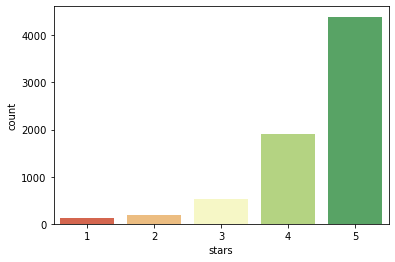

In [6]:
sns.countplot(x="stars", data=df, palette="RdYlGn")

## Převedení na širší kategorie

Učení jemnějších kategorií je náročnější, proto krajní hodnoty na každé straně sdružíme do košů a vytvoříme tři kategorie `NEGATIVE` (od 0 od 2), `NEUTRAL` (jen 3) a `POSITIVE` (od 4 do 5). K tomu nám poslouží pandas metoda [`cut`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).
Jelikož pracujeme s číselnými hodnotami, je podstatné, jestli jsou intervaly otevřené, nebo uzavřené, a na kterých koncích. Podrobnosti jsou v [dokumentaci metody cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html).

Výsledek uložíme do nového sloupce s názvem `sentiment`. Voláním stejné metody `countplot` na novém sloupci zobrazíme nové rozložení.

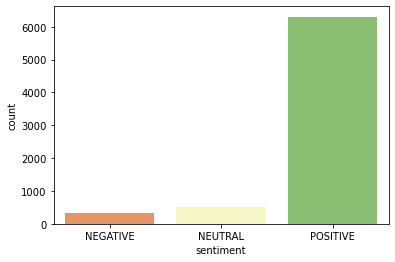

In [7]:
df["sentiment"] = pd.cut(df["stars"], 
                   bins=[0,2.9,3,5], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
sns.countplot(x="sentiment", data=df, palette="RdYlGn")

Metoda `cut` vytvořila sloupec `sentiment` jako kategoriální datový tip. V něm jsou pevně dané kategorie, které zefektivňují zpracování dat.

Nově vzniklé kategorie můžeme prozkoumat voláním funkce `dtype` na sloupci datového rámce.

In [8]:
df.sentiment.dtype

CategoricalDtype(categories=['NEGATIVE', 'NEUTRAL', 'POSITIVE'], ordered=True)

Pro přesné počty v kategoriích můžeme na datovém rámci zavolat metodu `groupby`. Parametrem je název sloupce `sentiment` ke kterému vytváříme skupiny.

In [9]:
df.groupby("sentiment").count()

stars  text
sentiment             
NEGATIVE     324   324
NEUTRAL      526   526
POSITIVE    6304  6304

## Odstranění neutrální kategorie

Prostřední kategorie `NEUTRAL` je pro učení problematická, protože obsahuje velmi nevyvážená textová hodnocení. Datový rámec můžeme na neutrální hodnocení omezit podmínkou uvedenou v hranatých závorkách, kde je uveden odkaz na slupec rámce `df.sentiment`, operátor rovnosti `==` a hodnota `NEUTRAL`, která nás zajímá.

In [10]:
df[df.sentiment == "NEUTRAL"]

stars                                               text sentiment
32        3  Nice suite! Spa was good except for the arroga...   NEUTRAL
111       3  The room was very small, the shower was terrib...   NEUTRAL
143       3  What you are served with is good food no doubt...   NEUTRAL
166       3  This place has a very unusual and traditional ...   NEUTRAL
203       3  Typically baroque and quite interesting. Worth...   NEUTRAL
...     ...                                                ...       ...
7138      3  Is in the center of everything. I have never h...   NEUTRAL
7139      3  You'd go for a beer and a pretzel, but dinner ...   NEUTRAL
7141      3  The beer is nice but the service is just so so...   NEUTRAL
7142      3  Good beer, nice pub-style food, bustling atmos...   NEUTRAL
7143      3  The beer is absolutely tops. Service was lukew...   NEUTRAL

[526 rows x 3 columns]

K odstranění všech řádků s neutrální kategorií použijeme pandas metodu [`drop`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html).

Funkce drop potřebuje jako vstup indexy řádků k odstranění. Ty snadno zjistíme voláním podmínky nad datovým rámcem a vlastosti `index`, kde je uložený seznam indexů.

In [11]:
indicies_to_drop = df[df.sentiment == "NEUTRAL"].index

indicies_to_drop

Int64Index([  32,  111,  143,  166,  203,  226,  232,  333,  373,  384,
            ...
            7109, 7115, 7116, 7120, 7121, 7138, 7139, 7141, 7142, 7143],
           dtype='int64', length=526)

Funkce `drop` pouze vrací kopii upraveného rámce, proto je potřeba jej zpět uložit do proměnné `df`.

Pro kontrolu pak vypíšeme počty kategorií opět metodou `groupby`.

In [12]:
df = df.drop(indicies_to_drop)

df.groupby("sentiment").count()

stars  text
sentiment             
NEGATIVE     324   324
NEUTRAL        0     0
POSITIVE    6304  6304

Jelikož kategorie zůstavá i bez výskytů, odebereme jí voláním `remove_unused_categories` nad vlastností `cat`, která umožňuje spravat kategorie sloupce.

Pro kontrolu zobrazíme graf a vypíšeme podobu kategorií.

CategoricalDtype(categories=['NEGATIVE', 'POSITIVE'], ordered=True)

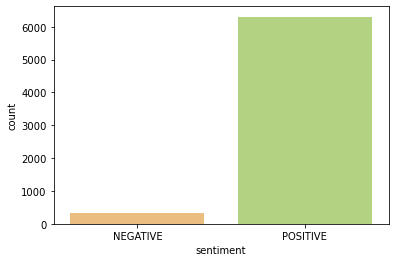

In [13]:
df.sentiment = df.sentiment.cat.remove_unused_categories()
sns.countplot(x="sentiment", data=df, palette="RdYlGn")
df.sentiment.dtype

## Vyvážení dat

Výrazně nevyvážené zastoupení kategorií by mohlo ovlivnit učení klasifikace textu. 

Pro vyvážení lze použít (a) **váhy** při trénování, nebo (b) **oversampling** Viz [doporučení na tenserflow](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data).
 
Tím, že jsme omezeni funkcionalitou spaCy pro možnosti tréninku (na úkor jenoduchosti), vybalancujeme model snížením četnosti pozitivních příspěvků (oversampling).

**Metoda**:
Vyvážení docílíme tím, že si připravíme dva řezy datovým rámcem, jeden s pozitivními komentáři a jeden s negativními. Z toho v četné kategorii vybereme náhodně vzorek dat, který se bude blížit počtu v druhé kategorii. Protože nemáme tolik dat, nemusí to být přesně 1:1 a četnější kategorie může drobně převládat. Rozdělené části pak spojíme zpět zřetězením.

Řezy si uložíme do proměnných `df_neg` a `df_pos`.

In [14]:
df_neg = df[df.sentiment=="NEGATIVE"]
df_pos = df[df.sentiment=="POSITIVE"]

Z četné kategorie vybereme náhodný vzorek pěti set řádků pandas funkcí [`sample`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html?highlight=sample#pandas.DataFrame.sample). Jako jediný parametr použijeme počet řádků (totéž jako pojmenovaný parametr `n`). Alternativně by šlo použít i proporcionální rozdělení, které nabízí parametr `frac`.

In [15]:
df_pos = df_pos.sample(500)

Jednotlivé části opět zřetězíme pandas funkcí [`concat`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html?highlight=concat#pandas.concat).

Parametry:
- `[df_neg, df_pos]` značí pole datových rámců pro zřetězení. Předpokládá se, že mají stejné sloupce. Pokud by němly vyplní se prázdné hodnoty.
- `ignore_index=True` ignoruje předešlý index a vytovoří nový.

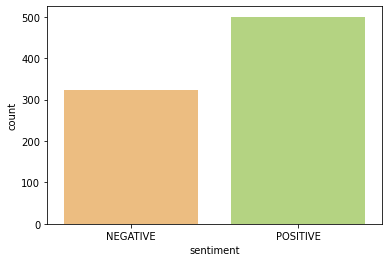

In [16]:
df = pd.concat([df_neg, df_pos], ignore_index=True)
sns.countplot(x="sentiment", data=df, palette="RdYlGn")

## Příprava formátu kategorií pro trénink

spaCy pro trénink očekává pojmenované pole s názvy kategorií jako klíči a logickými hodnotami kategorií. Pole uložíme nového sloupce `cats`.

Nejlepší způsob, jak uložit pojmenovaná pole do řádků datového rámce je připravit si je jako do pole velikosti počtu řádků datového rámce. To se snadno vytvoří iterací nad hodnotami sloupce `sentiment` v cyklu. Při každém průchodu se porovnají hodnoty sentimentu s hodnotami v pojmenovaném poly a zapíší do pole.

In [17]:
df["cats"] = [{"POSITIVE": y=="POSITIVE", "NEGATIVE": y=="NEGATIVE"} for y in df.sentiment]

## Rozělení na trénovací a testovací data

Před rozdělením je nezbytné promíchat data. K tomu nám pomůže opět funkce `sample`, na které budeme volat propocionální parametr `frac` s hodnotou `1`, která vrátí stejnou množinu dat, ale jinak uspořádanou.

In [18]:
df = df.sample(frac=1) #shuffle, případně i procentuální subset
df

stars                                               text sentiment  \
519      5  Having been a lifelong skier in the France and...  POSITIVE   
173      1  I was at the.Hotel Luna for two nights for a b...  NEGATIVE   
756      4  Stayed at Hotel Hell from 21-28 January 2012 o...  POSITIVE   
778      4  We had a great experience at this fairly recen...  POSITIVE   
28       1  We paid over 100 euros per night for three bed...  NEGATIVE   
..     ...                                                ...       ...   
483      5  We stayed for a week at the Hotel Cosmea. The ...  POSITIVE   
241      1  We had terrible food with a matching lousy ser...  NEGATIVE   
275      1  Went to the coffee bar for some breakfast. Nic...  NEGATIVE   
743      4  The hotel is just across the street from the t...  POSITIVE   
355      4  The restaurant is recently opened, and is easi...  POSITIVE   

                                      cats  
519  {'POSITIVE': True, 'NEGATIVE': False}  
173  {'POSITIVE': False, 'NEGATIVE': True}  
756  {'POSITIVE': True, 'NEGATIVE': False}  
778  {'POSITIVE': True, 'NEGATIVE': False}  
28   {'POSITIVE': False, 'NEGATIVE': True}  
..                                     ...  
483  {'POSITIVE': True, 'NEGATIVE': False}  
241  {'POSITIVE': False, 'NEGATIVE': True}  
275  {'POSITIVE': False, 'NEGATIVE': True}  
743  {'POSITIVE': True, 'NEGATIVE': False}  
355  {'POSITIVE': True, 'NEGATIVE': False}  

[824 rows x 4 columns]

Proporci rozdělení určíme jako 80% trénovacích a 20% testovacích dat. Pro rozdělení budeme potřebovat najít index předělového řádků.

In [19]:
split = 0.8
split_row = int(len(df) * split)
split_row

659

Se známým indexem předělového řádku zavoláme výběr z datového rámce pomocí výrazu s hranatými závorkami a dvojtečkou. Pozice dvojtečky oproti proměnné s indexem naznačuje, která část řádků se uloží. První menší část se uloží jako testovací, druhá větší jako trénovací. 

Pro kontrolu si zobrazíme délku množin.

In [20]:
df_test = df[split_row:]

len(df_test)

165

In [21]:
df_train = df[:split_row]

len(df_train)

659

## Formátování dat pro spaCy `update` a `evaluate` funkci
spaCy [`update`](https://spacy.io/api/textcategorizer#update) funkce objektu [`TextCategorizer`](https://spacy.io/api/textcategorizer) očekává kolekci dvojic s textem a anotacemi kategorií.

In [22]:
train_data = list(zip(df_train["text"], [{"cats": cats} for cats in df_train["cats"]]))
test_data = list(zip(df_test["text"], [{"cats": cats} for cats in df_test["cats"]]))

train_data[:3]

[('Having been a lifelong skier in the France and Austria being convinced to try Italy was not an easy task. I\'m pleased to say I\'ve been converted to Italy, Corvara and Col Alto. This is the ski holiday I\'ve been looking for. The hotel itself is better than anywhere I\'ve stayed in France and this really makes the entire ski experience perfect. After a hard day on the slopes and lunch you can return to your large room with gorgeous bathroom (a big deep tub and separate shower is always a plus) or relax in an almost endless number of ways in the spa. The bar / lounge area is lovely and although quietly buzzing (it\'s busier on nights with live music) you\'ll always find a seat (make sure you get a couch by the fire) and the dinner and wine selection is extensive (though I\'d recommend a bottle from the local grape). And if you\'ve got an ounce of energy left then there\'s the Iceberg bar / club to enjoy your ""one for the road"". For the first time for me on a ski holiday I was look

## Načtení jazykového modelu

In [23]:
import spacy
nlp = spacy.load("en_core_web_md")

## Vytvoření klasifikátoru

Vytvoříme novou pipeline komponentu pomocí [`nlp.create_pipe`](https://spacy.io/api/language#create_pipe).

Parametry:
- Na první pozici je parametr ID. Instance třídy TextCategorizer má vždy ID `textcat`.
- Konfigurace:
  - `exclusive_classes`, logická hodnota, zda jsou kategorie/třídy výlučné. Pozitivní a negativní sentiment je výlučný, proto použijeme `True`.
  - `architecture`, architekturu modelu lze vybrat z několika málo možností popsaných v [dokumentaci objektu TextCategorizer](https://spacy.io/api/textcategorizer#architectures). V tomto příkladu použijeme `simple_cnn`.

In [24]:
textcat = nlp.create_pipe("textcat",
                          config={"exclusive_classes": True,
                                  "architecture": "simple_cnn"})

Přidáme do pipeline [`nlp.add_pipe`](https://spacy.io/api/language#add_pipe). Parametr `last` určuje pozici, kam se má klasifikátor přidat.

In [25]:
nlp.add_pipe(textcat, last=True)

Do nově vytvořeného klasifikátoru přidáme kategorie `POSITIVE` a `NEGATIVE`.

In [26]:
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

textcat.labels # výpis pro ověření

('POSITIVE', 'NEGATIVE')

## Příprava velikosti várek (batches) pro trénink

Aby se model mohl postupně učit. Je třeba rozmyslet charakter procházení sady příkladů v tréninkové množině. V úvahu je třeba vzít, kdy model aktualizuje své parametry.

V zásadě existují tři způsoby aktualizace:
- Parametry se aktualizují po shlédnutí všech příkladů (batch). Způsob je přesnější ale náročnější na zdroje.
- Parametry se aktualizují po shlédnutí každého příkladu jednotlivě (stochastic). Méně přesné, ale méně náročné na zdroje. Může dojít k oscilaci při hledání minima.
- Něco mezi tím (minibatch), lze libovolně nastavit a proto volíme i v tomto případě.

Pro přípravu várek má spaCy dvě funkce:
- [`compouding`](https://spacy.io/api/top-level#util.compounding ) pro přípravu počtu příkladů ve várce,
- [`minibatch`](https://spacy.io/api/top-level#util.minibatch) pro přípravu sady příkladů.

Počet várek je ideální postupně zvyšovat (viz [tipy v dokumentaci](https://spacy.io/usage/training#tips-batch-size)). U klasifikátoru, je možné začít na vyšších počtech. 

In [27]:
from spacy.util import minibatch, compounding

In [28]:
batch_sizes = compounding(1.0, 32.0, 1.5)
for x in range(12): print(next(batch_sizes))

1.0
1.5
2.25
3.375
5.0625
7.59375
11.390625
17.0859375
25.62890625
32.0
32.0
32.0


Po opakovaném volání by `batch_sizes` vracela největší várku, proto musíme iterátor pokaždé znovu připravit.

Kromě `compunding` se hodí metoda `minibatch`, která podle velikostí várek rovnou připraví odpovídající části pole. 

Například:

In [29]:
batch_sizes = compounding(1.0, 4.0, 1.5)
for batch in minibatch(train_data[1:5], size=batch_sizes):
    print("\nbatch:", len(batch), batch)


batch: 1 [('I was at the.Hotel Luna for two nights for a business trip... Well was hard during that particoular week to find a room and I have got a double room confort for single use spending 152 euros per night! Well, the hotel from outside is worderful but inside is just old, everything is old and you feel like staying in a 2 stars hotel! The room was... Old... TV was... Old... Bathroom old and shower with plastic courtain! I mean 4 stars! Breackfast is nothing special and the attitude of the weiters very unfriendly.. I will try to avoid this hotel next time I will be there.', {'cats': {'POSITIVE': False, 'NEGATIVE': True}})]

batch: 1 [("Stayed at Hotel Hell from 21-28 January 2012 on a skiing trip. Very comfortable beds and duvets in a relatively quiet location. The hotel rooms and general areas were scrupulously clean. The hotel is a little way from the lift system but the hotel provide a shuttle bus, free of charge to transport the guests to and from the lifts. This was a very 

## Trénink

### Cykly tréninku
Trénink probíhá ve dvou do sebe vnořených cyklech:
1. iterace nad celou tréninkovou množinou (epocha) `for i in range(n_iter)`
1. iterace nad připravenými várkami příkladů `for batch in batches`

Počet iterací nad datasetem (epoch) nastavíme parametrem `n_iter`.

In [30]:
n_iter = 50

### Zamíchání příkladů

Při každé iteraci nad celou tréninkovou množinou se vzorek příkladů zamíchá `random.shuffle()`. Metodu je třeba importovat z knihovny `random`.

### Dropout rate
spaCy umožňuje pro trénink nastavit **dropout rate**. Dropout volíme vyšší kvůli menšímu počtu příkladů, u kterého by snáze mohlo dojít k přetrénování.

>Another technique to improve the learning results is to set a dropout rate, a rate at which to randomly “drop” individual features and representations. This makes it harder for the model to memorize the training data. For example, a 0.25 dropout means that each feature or internal representation has a 1/4 likelihood of being dropped.

In [31]:
dropout = 0.7

### Odebrání ostatních pipes
Při tréninku existujícího modelu je třeba dočasně odebrat ostatní pipes.
>If you’re using an existing model, make sure to disable all other pipeline components during training using [nlp.disable_pipes](https://spacy.io/api/language#disable_pipes)

In [32]:
# get names of other pipes to disable them during training
pipe_exceptions = ["textcat"] #, "trf_wordpiecer", "trf_tok2vec"
other_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

### Konstrukce `with`
V bloku pro trénink použijeme python konstrukci `with`, pomocí které
- můžeme pracovat s **dočasně** odebranýmy pipes modelu. `with nlp.disable_pipes(other_pipes)`
- Později ho použijeme i během iterací pro **dočasnou** aplikaci aktualizovaného modelu při evaluaci iterace. `with textcat.model.use_params(optimizer.averages)`

### Evaluace modelu
Evaluace modelu probíhá po každé iteraci na druhé části dat (`test_data`), které jsme si dali před tréninkem na stranu a připravili je do stejného formátu jako tréninková data. 

Pro účel evaluace modelu  nabízí spaCy třídu [`Scorer`](https://spacy.io/api/scorer). Nemusíme vytvářet instanci třídy, protože ji vrací `nlp.update`.

[`Scorer`](https://spacy.io/api/scorer) obsahuje tyto [vlastnosti](https://spacy.io/api/scorer#properties) relevantní k učení kategorií:
- slovník (pojmenované pole) `scores` všech skóre tříděné podle typu,
- hodnota `textcat_score` vyjadřuje F-score pro učení výlučných binárních kategorií (náš případ),
- slvník `textcat_per_cat` podle jednotlivých kategorií. Každá kategorie obsahuje
  - `p` **precision**, 
  - `r` **recall**,
  - `f` **F-score**.
  
Kromě objektu [`Scorer`](https://spacy.io/api/scorer) sledujeme také konečný výsledek ztrátové funkce, který se ukládá při každém volání `nlp.update` do proměnné `losses`.

Vyzkoušíme také evaluaci modelu z balíčku `sklearn`. Ten nabízí např. ROC (Receiver Operating Characteristic) křivku s AUC metrikou.
>ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

>The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

In [33]:
from sklearn import metrics # funkce pro skóring
import matplotlib.pyplot as plt # pro přístup k zobrazování grafu v iteracích
import numpy as np # numpy pro generování náhodných čísel

ROC křivka se získá funkcí [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html), kde první parametr `y` představuje testovací data, druhý parametr predikovaná data. `pos_label` umožňuje nastavit hodnotu, která ve skóre odpovídá `1`.

Jak by vypadala ROC křivka při náhodných odhadech?

In [34]:
y = df_test["sentiment"] # ["POSITIVE", "NEGATIVE", "POSITIVE", "NEGATIVE", ...]
random_scores = np.random.rand(len(df_test.sentiment)) # náhodné skóre od 0 (NEGATIVE) do 1 (POSITIVE)

fpr, tpr, thresholds = metrics.roc_curve(y, random_scores, pos_label="POSITIVE") # kalkulace ROC

AUC skóre vypočteme z výsledků `roc_curve` funkcí [`auc`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [35]:
metrics.auc(fpr, tpr)

0.5426997245179064

Zobrazení na grafu pomocí `seaborn` knihovny a funkce `lineplot`

[Text(0, 0.5, 'True Positive'), Text(0.5, 0, 'False Positive')]

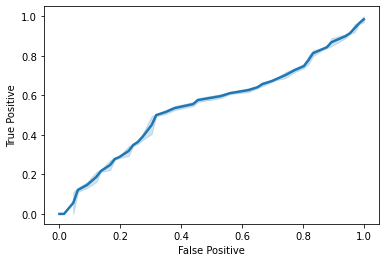

In [36]:
plot = sns.lineplot(x=fpr, y=tpr, linewidth=2.5)
plot.set(xlabel='False Positive', ylabel='True Positive')

Evaluace modelu vyžaduje v každé iteraci načíst velké množství dokumentů. Pokud nepoužijeme nativní funkci `evaluate`, je nejlepší možnost zpracovat dokumenty hromadně funkcí `Language.pipe`. Funkce  používá hromadné zpracován a je možné ji parametrizovat velikostí várek nebo paralelizací na více procesorů.

Funkce vrací generátor, který je možné použít jako paramter do listu a získat pole zpracovaných dokumentů.

In [37]:
import random # pro zamíchání příklady

In [38]:
score = pd.DataFrame() # dataframe pro výsledky
print("trénink", end="") # začátek tisku průběhu na řádek

with nlp.disable_pipes(other_pipes):  # s dočasně vypnutými ostatními pipes
    
    optimizer = nlp.begin_training() # vytvoření optimalizátoru    
    
    for i in range(n_iter): # iterace přes celou tréninkovou množinu (epocha)
        print(".", end="") # tisk průběhu další iterace na řádek
        losses = {} # příprava pro ukládání informací o ztrátách        
        random.shuffle(train_data) # zamíchání tréninkovou množinou
        
        batch_sizes = compounding(8.0, 40.0, 1.2) # inicializace počtu příkladů ve várkách
        batches = minibatch(train_data, size=batch_sizes) # načtení příkladů ve várkách
        
        for batch in batches: # učení se na každé várce 
            texts, annotations = zip(*batch) # uložení polí dvojic do dvou separátních polí
            
            nlp.update(texts, annotations, sgd=optimizer, drop=dropout, losses=losses) # samotné učení
        
        with textcat.model.use_params(optimizer.averages): # s dočasnou aplikací aktualizovaného modelu
            scorer = nlp.evaluate(test_data) # evaluace modelu na testovacích datech
            
            # vyplnění tabulky se skórem modelu v iteraci
            score.loc[i, "loss"] = losses["textcat"] # zapsání končené ztráty do tabulky
            score.loc[i,"F"] = scorer.textcat_score            
            score.loc[i,"P+"] = scorer.textcats_per_cat["POSITIVE"]["p"]
            score.loc[i,"R+"] = scorer.textcats_per_cat["POSITIVE"]["r"]
            score.loc[i,"F+"] = scorer.textcats_per_cat["POSITIVE"]["f"]
            score.loc[i,"P-"] = scorer.textcats_per_cat["NEGATIVE"]["p"]
            score.loc[i,"R-"] = scorer.textcats_per_cat["NEGATIVE"]["r"]
            score.loc[i,"F-"] = scorer.textcats_per_cat["NEGATIVE"]["f"]
            
            #alternativní skórování pomocí ROC a balíčku sklearn
            docs_generator = nlp.pipe(df_test["text"]) # dávkové zpracování testovacích dokumentů
            docs = list(docs_generator) # načtení testovacích dokumentů do listu
            scores = [doc.cats["POSITIVE"] for doc in docs] # načtení sentimentu do listu
            
            # kalkulace ROC
            fpr, tpr, thresholds = metrics.roc_curve(y_true = df_test["sentiment"], 
                                                     y_score = scores, 
                                                     pos_label = "POSITIVE")
            
            # vyplnění tabulky se skórem modelu v iteraci
            score.loc[i,"AUC"] = metrics.auc(fpr, tpr)
            
score #zobrazení tabulky se skóre po celém učení

trénink..................................................

loss          F         P+          R+         F+         P-  \
0   0.031260  37.500000  60.000000  100.000000  75.000000   0.000000   
1   0.026702  72.761905  73.809524   93.939394  82.666667  84.615385   
2   0.027899  58.953222  66.216216   98.989899  79.352227  94.117647   
3   0.023948  82.614634  83.962264   89.898990  86.829268  83.050847   
4   0.018239  83.219707  89.130435   82.828283  85.863874  76.712329   
5   0.023461  79.301948  92.207792   71.717172  80.681818  68.181818   
6   0.014348  84.091172  86.274510   88.888889  87.562189  82.539683   
7   0.013772  82.976190  82.882883   92.929293  87.619048  87.037037   
8   0.013313  86.636585  88.235294   90.909091  89.552239  85.714286   
9   0.013359  86.837607  90.625000   87.878788  89.230769  82.608696   
10  0.008477  87.373737  89.898990   89.898990  89.898990  84.848485   
11  0.011558  87.373737  89.898990   89.898990  89.898990  84.848485   
12  0.012657  89.344729  92.708333   89.898990  91.282051  85.507246   
13  0.014834  89.993936  93.684211   89.898990  91.752577  85.714286   
14  0.016378  85.852749  94.186047   81.818182  87.567568  77.215190   
15  0.013423  87.119438  96.428571   81.818182  88.524590  77.777778   
16  0.016967  87.119438  96.428571   81.818182  88.524590  77.777778   
17  0.008495  87.119438  96.428571   81.818182  88.524590  77.777778   
18  0.009881  87.119438  96.428571   81.818182  88.524590  77.777778   
19  0.014084  87.082945  95.348837   82.828283  88.648649  78.481013   
20  0.010446  87.119438  96.428571   81.818182  88.524590  77.777778   
21  0.007372  87.119438  96.428571   81.818182  88.524590  77.777778   
22  0.008366  86.523612  96.385542   80.808081  87.912088  76.829268   
23  0.008122  85.928288  96.341463   79.797980  87.292818  75.903614   
24  0.008161  86.523612  96.385542   80.808081  87.912088  76.829268   
25  0.005637  87.119438  96.428571   81.818182  88.524590  77.777778   
26  0.008133  87.715902  96.470588   82.828283  89.130435  78.750000   
27  0.007171  87.715902  96.470588   82.828283  89.130435  78.750000   
28  0.006559  87.119438  96.428571   81.818182  88.524590  77.777778   
29  0.008537  86.583383  98.734177   78.787879  87.640449  75.581395   
30  0.003554  87.180436  98.750000   79.797980  88.268156  76.470588   
31  0.003448  86.583383  98.734177   78.787879  87.640449  75.581395   
32  0.006872  85.986485  98.717949   77.777778  87.005650  74.712644   
33  0.007973  87.180436  98.750000   79.797980  88.268156  76.470588   
34  0.003936  87.777778  98.765432   80.808081  88.888889  77.380952   
35  0.009523  88.346158  97.619048   82.828283  89.617486  79.012346   
36  0.001224  87.777778  98.765432   80.808081  88.888889  77.380952   
37  0.003012  85.986485  98.717949   77.777778  87.005650  74.712644   
38  0.002527  85.959525  97.500000   78.787879  87.150838  75.294118   
39  0.001280  86.583383  98.734177   78.787879  87.640449  75.581395   
40  0.000806  87.777778  98.765432   80.808081  88.888889  77.380952   
41  0.002553  86.583383  98.734177   78.787879  87.640449  75.581395   
42  0.008500  87.777778  98.765432   80.808081  88.888889  77.380952   
43  0.001559  87.777778  98.765432   80.808081  88.888889  77.380952   
44  0.001372  88.973864  98.795181   82.828283  90.109890  79.268293   
45  0.001546  88.375542  98.780488   81.818182  89.502762  78.313253   
46  0.001087  88.375542  98.780488   81.818182  89.502762  78.313253   
47  0.001250  88.375542  98.780488   81.818182  89.502762  78.313253   
48  0.003165  88.973864  98.795181   82.828283  90.109890  79.268293   
49  0.000790  88.973864  98.795181   82.828283  90.109890  79.268293   

           R-         F-       AUC  
0    0.000000   0.000000  0.862718  
1   50.000000  62.857143  0.899296  
2   24.242424  38.554217  0.898378  
3   74.242424  78.400000  0.907713  
4   84.848485  80.575540  0.915366  
5   90.909091  77.922078  0.921335  
6   78.787879  80.620155  0.926538  
7   71.212121  78.333333  0.929140  
8 

### Vykreslení ROC pro finální model

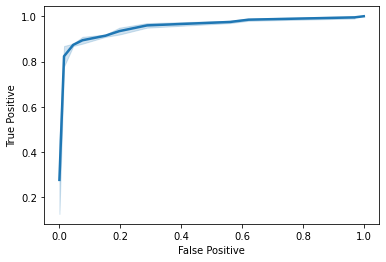

In [39]:
#alternativní skórování pomocí ROC a balíčku sklearn
docs_generator = nlp.pipe(df_test["text"]) # dávkové zpracování testovacích dokumentů
docs = list(docs_generator) # načtení testovacích dokumentů do listu
scores = [doc.cats["POSITIVE"] for doc in docs] # načtení sentimentu do listu

# kalkulace ROC
fpr, tpr, thresholds = metrics.roc_curve(y_true = df_test["sentiment"], 
                                         y_score = scores, 
                                         pos_label = "POSITIVE")

# zobrazení ROC grafu
roc_plot = sns.lineplot(x=fpr, y=tpr, linewidth=2.5)
roc_plot.set(xlabel='False Positive', ylabel='True Positive')
plt.show() # zobrazení křivky za běhu buňky

Po uložení na disk, můžeme model opakovaně načítat a používat.

Při ukládání použijeme v dočasné zprůměrování parametrů (konstrukce `with`) modelu voláním `use_params` na model s parametrem průměrných vah získaných z optimalizátoru pomocí `optimizer.averages`.
>The last part of our optimization recipe is parameter averaging, an old trick introduced by Freund and Schapire (1999), popularized in the NLP community by Collins (2002), and explained in more detail by Leon Bottou. Just about the only other people who seem to be using this for neural network training are the SyntaxNet team (one of whom is Michael Collins) – but it really seems to work great on every problem.

In [40]:
with nlp.use_params(optimizer.averages):
    nlp.to_disk(output_dir)
print("Saved model to", output_dir)

Saved model to model_categorizer


## Vyzkoušení modelu na novém rámci
Natrénovaný model si vyzkoušíme na sadě textů. K tomu si připravíme nový datový rámec.

In [41]:
examples = pd.DataFrame(["The rooms were clean.", "They went over and beyond to help make our stay enjoyable.",
                         "The breakfast is one of the best I have ever had in Europe.",
                         "I highly recommend this hotel for anyone visiting downtown", 
                         "We got to hotel super early", "The sevice was exceptional as well.",
                         "Every staff member I encountered were delightful and eager to help!",
                         "The bed was extremely comfortable.", "The room was spacious and clean.",
                         "Beautiful atmosphere inside and outside around that part of the city.",
                         "Everything what you need is possible.", "The room was huge, modern, and spotless.",
                         "This is a beautiful hotel!", "The environment was pleasant and welcoming.",
                         "We could park our motorcycles in the closed garage.", "Great value for money.",
                         "Must definitelly recommend breakfast, good food and variety of it.",
                         "Hot water constantly running out.", "Virtually no cooking utensils",
                         "Beds were extremely uncomfortable", "Pillows were solid hurting your neck when you slept.",
                         "My kid broke his arm there.", "Worst hotel I've stayed in.", "No Wi-Fi inside rooms.",
                         "Fridge was dirty and horrible and the bottom of it was rusty.", "Back-pain guaranteed.",
                         "Only way to let some fresh air inside is to open the main door.", 
                         "Limited hot water in apartments", "Barely slept all week.", 
                         "Staff are extremely rude and unhelpful", "Majority of hotel staff were miserable",
                         "Rooms smelt of cheap air freshener in an attempt to cover up a bad smell.",
                         "Furniture was cheap and didn't match (not a big deal)", "Smells very very ugly from bathroom.",
                         "standards were below what we were expecting."
                        ], 
                        columns=["text"])
examples

text
0                               The rooms were clean.
1   They went over and beyond to help make our sta...
2   The breakfast is one of the best I have ever h...
3   I highly recommend this hotel for anyone visit...
4                         We got to hotel super early
5                 The sevice was exceptional as well.
6   Every staff member I encountered were delightf...
7                  The bed was extremely comfortable.
8                    The room was spacious and clean.
9   Beautiful atmosphere inside and outside around...
10              Everything what you need is possible.
11           The room was huge, modern, and spotless.
12                         This is a beautiful hotel!
13        The environment was pleasant and welcoming.
14  We could park our motorcycles in the closed ga...
15                             Great value for money.
16  Must definitelly recommend breakfast, good foo...
17                  Hot water constantly running out.
18                      Virtually no cooking utensils
19                  Beds were extremely uncomfortable
20  Pillows were solid hurting your neck when you ...
21                        My kid broke his arm there.
22                        Worst hotel I've stayed in.
23                             No Wi-Fi inside rooms.
24  Fridge was dirty and horrible and the bottom o...
25                              Back-pain guaranteed.
26  Only way to let some fresh air inside is to op...
27                    Limited hot water in apartments
28                             Barely slept all week.
29             Staff are extremely rude and unhelpful
30             Majority of hotel staff were miserable
31  Rooms smelt of cheap air freshener in an attem...
32  Furniture was cheap and didn't match (not a bi...
33               Smells very very ugly from bathroom.
34       standards were below what we were expecting.

Pro operace s datovými rámci není efektivní iterovat, ale provádět vektorové operace např. pomocí flexibilního volání libovolné funkce pomocí [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html). 

Parametry [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html):
- jméno funkce, např. `np.sum` pro součet, 
- osu `axis` po které se apply provede
  - `0` se aplikuje po sloupcích
  - `1` se aplikuje po řádcích
- argumenty pro volanou funkci

Pro [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html) si připravíme novou funkci `evaluate`. Jako parametr budeme očekávat řádek (sérii) `row` a jazykový model `nlp`, který vrací kategorie `POSITIVE` a `NEGATIVE`.

Do řádku přidáme nový sloupec `sentiment_score`, kam uložíme predikovanou hodnotu sentimentu. Stačí uložit pozitivní sentiment, protože kategorie jsou výlučné.

In [42]:
def evaluate(row, nlp=nlp):
    row["sentiment_score"]=nlp(row["text"]).cats["POSITIVE"]    
    return row

Pokud bychom chtěli sentiment jako kategorii, použijeme opět pandas funkci `pd.cut`, která nám z číselných hodnot vytvoří kategorie dle nastavených košů.

In [43]:
examples = examples.apply(evaluate, nlp=nlp, axis=1)

examples["sentiment"] = pd.cut(examples["sentiment_score"], 
                   bins=[0,0.4,0.6,1], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
examples

text  sentiment_score  \
0                               The rooms were clean.     9.999168e-01   
1   They went over and beyond to help make our sta...     9.995838e-01   
2   The breakfast is one of the best I have ever h...     9.777607e-01   
3   I highly recommend this hotel for anyone visit...     9.503336e-01   
4                         We got to hotel super early     9.277351e-02   
5                 The sevice was exceptional as well.     1.000000e+00   
6   Every staff member I encountered were delightf...     1.000000e+00   
7                  The bed was extremely comfortable.     1.000000e+00   
8                    The room was spacious and clean.     9.999921e-01   
9   Beautiful atmosphere inside and outside around...     8.197229e-02   
10              Everything what you need is possible.     1.435700e-03   
11           The room was huge, modern, and spotless.     1.000000e+00   
12                         This is a beautiful hotel!     1.000000e+00   
13        The environment was pleasant and welcoming.     1.000000e+00   
14  We could park our motorcycles in the closed ga...     9.973881e-01   
15                             Great value for money.     3.243470e-01   
16  Must definitelly recommend breakfast, good foo...     1.000000e+00   
17                  Hot water constantly running out.     9.141535e-03   
18                      Virtually no cooking utensils     3.558590e-13   
19                  Beds were extremely uncomfortable     2.932324e-13   
20  Pillows were solid hurting your neck when you ...     4.159311e-09   
21                        My kid broke his arm there.     1.938465e-05   
22                        Worst hotel I've stayed in.     9.999998e-01   
23                             No Wi-Fi inside rooms.     9.999985e-01   
24  Fridge was dirty and horrible and the bottom o...     3.852314e-09   
25                              Back-pain guaranteed.     1.000000e+00   
26  Only way to let some fresh air inside is to op...     9.104188e-11   
27                    Limited hot water in apartments     3.785916e-14   
28                             Barely slept all week.     1.000000e+00   
29             Staff are extremely rude and unhelpful     2.869585e-10   
30             Majority of hotel staff were miserable     9.956270e-01   
31  Rooms smelt of cheap air freshener in an attem...     9.731119e-09   
32  Furniture was cheap and didn't match (not a bi...     1.486928e-13   
33               Smells very very ugly from bathroom.     6.949557e-02   
34       standards were below what we were expecting.     1.704047e-13   

   sentiment  
0   POSITIVE  
1   POSITIVE  
2   POSITIVE  
3   POSITIVE  
4   NEGATIVE  
5   POSITIVE  
6   POSITIVE  
7   POSITIVE  
8   POSITIVE  
9   NEGATIVE  
10  NEGATIVE  
11  POSITIVE  
12  POSITIVE  
13  POSITIVE  
14  POSITIVE  
15  NEGATIVE  
16  POSITIVE  
17  NEGATIVE  
18  NEGATIVE  
19  NEGATIVE  
20  NEGATIVE  
21  NEGATIVE  
22  POSITIVE  
23  POSITIVE  
24  NEGATIVE  
25  POSITIVE  
26  NEGATIVE  
27  NEGATIVE  
28  POSITIVE  
29  NEGATIVE  
30  POSITIVE  
31  NEGATIVE  
32  NEGATIVE  
33  NEGATIVE  
34  NEGATIVE

### Vyzkoušení modelu z disku
Abychom vyzkoušeli i uložený model na disku, model načteme z adresáře metodou `spacy.load`.

In [44]:
# test the saved model
nlp_disk = spacy.load(output_dir)

Zkopírujeme rámec s příklady a aplikujeme na něj naší funkci `evaluate`, ale tentokrát s novým jazykovým modelem.

In [45]:
examples_disk = examples.copy()
examples_disk = examples_disk.apply(evaluate, nlp=nlp_disk, axis=1)
examples_disk["sentiment"] = pd.cut(examples_disk["sentiment_score"], 
                   bins=[0,0.4,0.6,1], 
                   labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
examples_disk

text  sentiment_score  \
0                               The rooms were clean.     9.994361e-01   
1   They went over and beyond to help make our sta...     9.994169e-01   
2   The breakfast is one of the best I have ever h...     9.724310e-01   
3   I highly recommend this hotel for anyone visit...     8.897025e-01   
4                         We got to hotel super early     9.979305e-01   
5                 The sevice was exceptional as well.     1.000000e+00   
6   Every staff member I encountered were delightf...     9.999999e-01   
7                  The bed was extremely comfortable.     1.000000e+00   
8                    The room was spacious and clean.     9.999549e-01   
9   Beautiful atmosphere inside and outside around...     9.310161e-01   
10              Everything what you need is possible.     2.013546e-04   
11           The room was huge, modern, and spotless.     9.999998e-01   
12                         This is a beautiful hotel!     1.000000e+00   
13        The environment was pleasant and welcoming.     1.000000e+00   
14  We could park our motorcycles in the closed ga...     9.479242e-01   
15                             Great value for money.     3.802711e-01   
16  Must definitelly recommend breakfast, good foo...     1.000000e+00   
17                  Hot water constantly running out.     1.528151e-02   
18                      Virtually no cooking utensils     1.563951e-12   
19                  Beds were extremely uncomfortable     1.016090e-12   
20  Pillows were solid hurting your neck when you ...     8.686260e-09   
21                        My kid broke his arm there.     5.696401e-06   
22                        Worst hotel I've stayed in.     9.999409e-01   
23                             No Wi-Fi inside rooms.     9.999521e-01   
24  Fridge was dirty and horrible and the bottom o...     1.946822e-09   
25                              Back-pain guaranteed.     9.999946e-01   
26  Only way to let some fresh air inside is to op...     3.220527e-10   
27                    Limited hot water in apartments     1.367466e-12   
28                             Barely slept all week.     1.000000e+00   
29             Staff are extremely rude and unhelpful     8.573734e-10   
30             Majority of hotel staff were miserable     9.882229e-01   
31  Rooms smelt of cheap air freshener in an attem...     2.633985e-08   
32  Furniture was cheap and didn't match (not a bi...     2.387313e-12   
33               Smells very very ugly from bathroom.     1.620535e-02   
34       standards were below what we were expecting.     1.024783e-12   

   sentiment  
0   POSITIVE  
1   POSITIVE  
2   POSITIVE  
3   POSITIVE  
4   POSITIVE  
5   POSITIVE  
6   POSITIVE  
7   POSITIVE  
8   POSITIVE  
9   POSITIVE  
10  NEGATIVE  
11  POSITIVE  
12  POSITIVE  
13  POSITIVE  
14  POSITIVE  
15  NEGATIVE  
16  POSITIVE  
17  NEGATIVE  
18  NEGATIVE  
19  NEGATIVE  
20  NEGATIVE  
21  NEGATIVE  
22  POSITIVE  
23  POSITIVE  
24  NEGATIVE  
25  POSITIVE  
26  NEGATIVE  
27  NEGATIVE  
28  POSITIVE  
29  NEGATIVE  
30  POSITIVE  
31  NEGATIVE  
32  NEGATIVE  
33  NEGATIVE  
34  NEGATIVE

## Byznys analýza
V praxi nestačí jen klasifikovat text do kategorií, hlavní hodnota tkví v propojení s dalšími kategoriálními daty, které přidají kategoriím kontext. Přidáme sloupec s kategoriemi, které budou označovat hotel, ke kterému se komentář váže.

In [46]:
import numpy as np
random_hotels = np.random.choice(["Modrá Hvězda", "Hotel Praha", "Hotel Moskva"], 
                                 size=len(examples.index))

examples.loc[:,"hotel"] = pd.Series(random_hotels, dtype="category")
examples

text  sentiment_score  \
0                               The rooms were clean.     9.999168e-01   
1   They went over and beyond to help make our sta...     9.995838e-01   
2   The breakfast is one of the best I have ever h...     9.777607e-01   
3   I highly recommend this hotel for anyone visit...     9.503336e-01   
4                         We got to hotel super early     9.277351e-02   
5                 The sevice was exceptional as well.     1.000000e+00   
6   Every staff member I encountered were delightf...     1.000000e+00   
7                  The bed was extremely comfortable.     1.000000e+00   
8                    The room was spacious and clean.     9.999921e-01   
9   Beautiful atmosphere inside and outside around...     8.197229e-02   
10              Everything what you need is possible.     1.435700e-03   
11           The room was huge, modern, and spotless.     1.000000e+00   
12                         This is a beautiful hotel!     1.000000e+00   
13        The environment was pleasant and welcoming.     1.000000e+00   
14  We could park our motorcycles in the closed ga...     9.973881e-01   
15                             Great value for money.     3.243470e-01   
16  Must definitelly recommend breakfast, good foo...     1.000000e+00   
17                  Hot water constantly running out.     9.141535e-03   
18                      Virtually no cooking utensils     3.558590e-13   
19                  Beds were extremely uncomfortable     2.932324e-13   
20  Pillows were solid hurting your neck when you ...     4.159311e-09   
21                        My kid broke his arm there.     1.938465e-05   
22                        Worst hotel I've stayed in.     9.999998e-01   
23                             No Wi-Fi inside rooms.     9.999985e-01   
24  Fridge was dirty and horrible and the bottom o...     3.852314e-09   
25                              Back-pain guaranteed.     1.000000e+00   
26  Only way to let some fresh air inside is to op...     9.104188e-11   
27                    Limited hot water in apartments     3.785916e-14   
28                             Barely slept all week.     1.000000e+00   
29             Staff are extremely rude and unhelpful     2.869585e-10   
30             Majority of hotel staff were miserable     9.956270e-01   
31  Rooms smelt of cheap air freshener in an attem...     9.731119e-09   
32  Furniture was cheap and didn't match (not a bi...     1.486928e-13   
33               Smells very very ugly from bathroom.     6.949557e-02   
34       standards were below what we were expecting.     1.704047e-13   

   sentiment         hotel  
0   POSITIVE  Hotel Moskva  
1   POSITIVE  Hotel Moskva  
2   POSITIVE  Hotel Moskva  
3   POSITIVE  Modrá Hvězda  
4   NEGATIVE  Hotel Moskva  
5   POSITIVE   Hotel Praha  
6   POSITIVE  Hotel Moskva  
7   POSITIVE  Modrá Hvězda  
8   POSITIVE   Hotel Praha  
9   NEGATIVE  Hotel Moskva  
10  NEGATIVE   Hotel Praha  
11  POSITIVE  Modrá Hvězda  
12  POSITIVE  Modrá Hvězda  
13  POSITIVE  Hotel Moskva  
14  POSITIVE  Hotel Moskva  
15  NEGATIVE  Modrá Hvězda  
16  POSITIVE   Hotel Praha  
17  NEGATIVE   Hotel Praha  
18  NEGATIVE   Hotel Praha  
19  NEGATIVE  Modrá Hvězda  
20  NEGATIVE   Hotel Praha  
21  NEGATIVE  Modrá Hvězda  
22  POSITIVE  Modrá Hvězda  
23  POSITIVE  Hotel Moskva  
24  NEGATIVE  Modrá Hvězda  
25  POSITIVE   Hotel Praha  
26  NEGATIVE  Modrá Hvězda  
27  NEGATIVE   Hotel Praha  
28  POSITIVE  Hotel Moskva  
29  NEGATIVE  Modrá Hvězda  
30  POSITIVE   Hotel Praha  
31  NEGATIVE  Modrá Hvězda  
32  NEGATIVE   Hotel Praha  
33  NEGATIVE  Modrá Hvězda  
34  NEGATIVE  Modrá Hvězda

Zkontrolujeme, jak se vytvořily kategorie v datovém typu sloupce.

In [47]:
examples.hotel.dtype

CategoricalDtype(categories=['Hotel Moskva', 'Hotel Praha', 'Modrá Hvězda'], ordered=False)

### Vizualizace
Vizualizovat datový rámec můžeme opět pomocí [seaborn](https://seaborn.pydata.org/) knihovny.

Protože potřebujeme zobrazit více dat, můžeme použít legendu, která se předá jako název sloupce pro parametr `hue`.

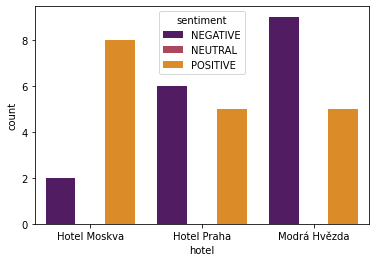

In [48]:
sns.countplot(x="hotel", hue="sentiment", data=examples, palette="inferno")

### Kontingenční tabulka

Nad kategoriálními daty jdou efektivně provádět operace, jako například groupby nebo pivot. Viz [operace s kategoriálními daty](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html#operations) v dokumentaci pandas.

Funkce [`pivot_table`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pivot_table.html#pandas-dataframe-pivot-table) potřebuje jen několik parametrů:
- datový rámec na první pozici,
- `values` jako sloupec s hodnotami,
- `aggfunc` agregační funkci, která se aplikuje na hodnoty,
- `margins` součtové řádky
- `index` s polem sloupců, které budou tvořit index nové tabulky. Pole je to proto, že index může být hierarchický.

Pro přehlednost ještě seřadíme rámec podle sentimentu funkcí [`sort_values`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html).

In [49]:
pd.pivot_table(examples, 
               values="sentiment_score", 
               aggfunc=["mean", "min", "max"], 
               index="hotel", 
               margins=True)

mean             min             max
             sentiment_score sentiment_score sentiment_score
hotel                                                       
Hotel Moskva        0.814939    8.197229e-02             1.0
Hotel Praha         0.455109    3.785916e-14             1.0
Modrá Hvězda        0.381728    1.704047e-13             1.0
All                 0.528565    3.785916e-14             1.0

Případně s kategoriemi sentimentu jako dalším sloupcem indexu.

In [50]:
pd.pivot_table(examples, 
               values=["sentiment_score", "sentiment"], 
               aggfunc={"sentiment_score":"mean", "sentiment":"count"}, 
               index=["hotel", "sentiment"],
               margins=True)

sentiment  sentiment_score
hotel        sentiment                            
Hotel Moskva NEGATIVE           2         0.087373
             NEUTRAL            0              NaN
             POSITIVE           8         0.996831
Hotel Praha  NEGATIVE           6         0.001763
             NEUTRAL            0              NaN
             POSITIVE           5         0.999124
Modrá Hvězda NEGATIVE           9         0.043762
             NEUTRAL            0              NaN
             POSITIVE           5         0.990067
All                            35         0.528565

### Korelační matice
V pandas lze velmi snadno sestavit korelační matici pomocí funkce [`corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html).

Nejdříve si vytvoříme náhodný sloupec pro ilustraci. Použijeme opět `numpy.random` ale tentoktrát funkci `rand`. Funkce potřebuje jen počty čísle pro generování, co parametr to počet v jedné dimenzi.

In [51]:
random_scores = np.random.rand(len(examples.index))

examples.loc[:,"rand_score"] = pd.Series(random_scores, dtype="float")
examples

text  sentiment_score  \
0                               The rooms were clean.     9.999168e-01   
1   They went over and beyond to help make our sta...     9.995838e-01   
2   The breakfast is one of the best I have ever h...     9.777607e-01   
3   I highly recommend this hotel for anyone visit...     9.503336e-01   
4                         We got to hotel super early     9.277351e-02   
5                 The sevice was exceptional as well.     1.000000e+00   
6   Every staff member I encountered were delightf...     1.000000e+00   
7                  The bed was extremely comfortable.     1.000000e+00   
8                    The room was spacious and clean.     9.999921e-01   
9   Beautiful atmosphere inside and outside around...     8.197229e-02   
10              Everything what you need is possible.     1.435700e-03   
11           The room was huge, modern, and spotless.     1.000000e+00   
12                         This is a beautiful hotel!     1.000000e+00   
13        The environment was pleasant and welcoming.     1.000000e+00   
14  We could park our motorcycles in the closed ga...     9.973881e-01   
15                             Great value for money.     3.243470e-01   
16  Must definitelly recommend breakfast, good foo...     1.000000e+00   
17                  Hot water constantly running out.     9.141535e-03   
18                      Virtually no cooking utensils     3.558590e-13   
19                  Beds were extremely uncomfortable     2.932324e-13   
20  Pillows were solid hurting your neck when you ...     4.159311e-09   
21                        My kid broke his arm there.     1.938465e-05   
22                        Worst hotel I've stayed in.     9.999998e-01   
23                             No Wi-Fi inside rooms.     9.999985e-01   
24  Fridge was dirty and horrible and the bottom o...     3.852314e-09   
25                              Back-pain guaranteed.     1.000000e+00   
26  Only way to let some fresh air inside is to op...     9.104188e-11   
27                    Limited hot water in apartments     3.785916e-14   
28                             Barely slept all week.     1.000000e+00   
29             Staff are extremely rude and unhelpful     2.869585e-10   
30             Majority of hotel staff were miserable     9.956270e-01   
31  Rooms smelt of cheap air freshener in an attem...     9.731119e-09   
32  Furniture was cheap and didn't match (not a bi...     1.486928e-13   
33               Smells very very ugly from bathroom.     6.949557e-02   
34       standards were below what we were expecting.     1.704047e-13   

   sentiment         hotel  rand_score  
0   POSITIVE  Hotel Moskva    0.362196  
1   POSITIVE  Hotel Moskva    0.749253  
2   POSITIVE  Hotel Moskva    0.292602  
3   POSITIVE  Modrá Hvězda    0.469791  
4   NEGATIVE  Hotel Moskva    0.839356  
5   POSITIVE   Hotel Praha    0.754201  
6   POSITIVE  Hotel Moskva    0.693819  
7   POSITIVE  Modrá Hvězda    0.389446  
8   POSITIVE   Hotel Praha    0.755176  
9   NEGATIVE  Hotel Moskva    0.537130  
10  NEGATIVE   Hotel Praha    0.165393  
11  POSITIVE  Modrá Hvězda    0.214287  
12  POSITIVE  Modrá Hvězda    0.450160  
13  POSITIVE  Hotel Moskva    0.239188  
14  POSITIVE  Hotel Moskva    0.526280  
15  NEGATIVE  Modrá Hvězda    0.073253  
16  POSITIVE   Hotel Praha    0.457186  
17  NEGATIVE   Hotel Praha    0.531672  
18  NEGATIVE   Hotel Praha    0.667706  
19  NEGATIVE  Modrá Hvězda    0.683727  
20  NEGATIVE   Hotel Praha    0.055250  
21  NEGATIVE  Modrá Hvězda    0.704786  
22  POSITIVE  Modrá Hvězda    0.547442  
23  POSITIVE  Hotel Moskva    0.359821  
24  NEGATIVE  Modrá Hvězda    0.874168  
25  POSITIVE   Hotel Praha    0.008326  
26  NEGATIVE  Modrá Hvězda    0.283552  
27  NEGATIVE   Hotel Praha    0.627316  
28  POSITIVE  Hotel Moskva    0.211090  
29  NEGATIVE  Modrá Hvězda    0.452777  
30  POSITIVE   Hotel Praha    0.809716  
31  NEGATIVE  Modrá Hvězda    0.890055  
32  NEGATIVE   Hotel Praha    0

Pak už jen zavoláme [`corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) na našem datovém rámci. Jako parametr lze vybrat konkrétní metodu.
>Method of correlation:
>- pearson : standard correlation coefficient
>- kendall : Kendall Tau correlation coefficient
>- spearman : Spearman rank correlation

In [52]:
examples.corr()

sentiment_score  rand_score
sentiment_score         1.000000   -0.137006
rand_score             -0.137006    1.000000

## Zpětná vazba
Na konci workshopu prosím vyplňte [zpětnovazební dotazník](https://forms.office.com/Pages/ResponsePage.aspx?id=s6RRKz9EBkSMpBkFanmkRDrVrOWRmgNKoJ-3FBxiROBURVpPVDlVS09ZM0VSTkdRQ1JGRzdTT05IRy4u). Dotazník slouží pro ověření, že pro Vás byl obsah zajímavý a věnovali jste mu pozornost.
